In [1]:
import os
import pandas as pd
import numpy as np
from __future__ import division
import operator
pd.set_option('display.float_format', lambda x: '%.3f' % x)

os.getcwd()
base_ds = pd.read_csv(os.getcwd() + '\DS Homework\meps_base_data.csv',index_col=[0])
meds_ds = pd.read_csv(os.getcwd() + '\DS Homework\meps_meds.csv',index_col=[0])

print len(base_ds),len(meds_ds)

# Cleaning the base and meds file
# Removing duplicate rows 
base_ds_2 = base_ds.drop_duplicates().reset_index(drop = True)
meds_ds_2 = meds_ds.drop_duplicates().reset_index(drop = True)

print len(base_ds_2),len(meds_ds_2)

C:\Users\dhrugarg\AppData\Local\Continuum\anaconda2\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


61489 1148347
61489 377386


# Data Preperation 

In [2]:
# Exploring the data/ Doing some basic checks on the meds_ds

# 1- Is there one to one mapping between rxNDC and rx Name
print 'No unique rxnames: %d , No unique rxNDCs: %d' %(meds_ds_2['rxName'].nunique() , meds_ds_2['rxNDC'].nunique())
a = meds_ds_2.groupby(by = ['rxName'])[['rxNDC']].nunique()
b = a.sort_values(by = ['rxNDC'],ascending = False).reset_index()
b.head(5)

# We can safely assume that there are different NDC's for the same rxname because of different manufacturers.
# but the drug is the same. Hence we will consider rxname as the primary key/indicator of a new drug taken rather than
# the rxNDC.

No unique rxnames: 9218 , No unique rxNDCs: 28736


,rxName,rxNDC
0,LISINOPRIL,471
1,SIMVASTATIN,352
2,METFORMIN,329
3,IBUPROFEN,321
4,AMOXICILLIN,289


In [3]:
# 2a- Checking for erronous data in each of the variables in MEDS data  - 
#Text vars in numerical cols , negetive values when + ve expected, data length shorter than expected


print meds_ds_2.dtypes
print 'All except name and form are int or float so no non numerical values wherever not expected'
print ('')
print meds_ds_2.describe()
print ''
print 'Checking if Name and form have numeric values and replacing them with Null/missing indicator'

for i in ['rxName','rxForm']:
    print 'String having mispopulated values for %s : %d' %(i,len(meds_ds_2.loc[pd.to_numeric(meds_ds_2[i], errors='coerce').notnull(),i]))
    meds_ds_2.loc[pd.to_numeric(meds_ds_2[i], errors='coerce').notnull(),i]  = 'missing'
    
    
print ''
print('We can see that apart from id the other 4 variables have negetive values. Logically this dosent make sense so assuming the negetives are missing data and repalcing with null')

meds_ds_3 = meds_ds_2.applymap(lambda x: x if x>0 else np.nan)

print ''
print meds_ds_3.describe()
print ''
print '% of missing in each field'
((meds_ds_3.isnull().sum()/len(meds_ds_3))*100).apply(round,args = (5,))



id                int64
rxStartMonth      int64
rxStartYear       int64
rxName           object
rxNDC             int64
rxQuantity      float64
rxForm           object
dtype: object
All except name and form are int or float so no non numerical values wherever not expected

                id  rxStartMonth  rxStartYear           rxNDC  rxQuantity
count   377386.000    377386.000   377386.000      377386.000  377386.000
mean  57169669.514         1.474     1350.421 23458422554.510      63.792
std   26972828.695         4.691      942.259 28411146273.798     459.470
min   10007101.000        -9.000      -14.000          -9.000      -9.000
25%   41502351.750        -1.000       -1.000   169231421.000      30.000
50%   70983101.000        -1.000     2006.000   603158558.000      30.000
75%   81863102.000         4.000     2009.000 54868499201.000      90.000
max   89688102.000        12.000     2011.000 99207074560.000  120000.000

Checking if Name and form have numeric values and replacing

id              0.000
rxStartMonth   60.105
rxStartYear    32.633
rxName          0.000
rxNDC           0.310
rxQuantity      0.039
rxForm          0.000
dtype: float64

In [4]:
# 2b- Checking for erronous data in each of the variables in Base data  - 

print base_ds_2.describe()
print 'All 4 Id,panel,weight,age are float/int so non numerical values wherever not expected'
print ('')
print('Of the 4 numeric vars age has negetives which is a data error so replacing with null')

base_ds_3 = base_ds_2.applymap(lambda x: x if x>0 else np.nan)
print ''
print base_ds_3.describe()


print 'Checking if any of the string variables have numeric values and replacing them with Null'

for i in list(base_ds_3.columns)[4:]:
    print 'String having mispopulated values for %s : %d' %(i,len(base_ds_3.loc
                                                                  [pd.to_numeric(base_ds_3[i], errors='coerce').notnull(),i]))
    base_ds_3.loc[pd.to_numeric(base_ds_3[i], errors='coerce').notnull(),i]  = np.nan

print 'Going through unique values in the string columns to check if the levels make sense or not'

for i in list(base_ds_3.columns)[4:]:
    print (i,base_ds_3[i].unique())

print ''
print 'Checking for missing values and replacing with median value for the variable'

miss_per = ((base_ds_3.isnull().sum()/len(base_ds_3))*100).apply(round,args = (5,))
print miss_per[miss_per >0]

base_ds_3.loc[base_ds_3['age'].isnull(),'age'] = base_ds_3['age'].median()

                id     panel  pooledWeight       age
count    61489.000 61489.000     61489.000 61489.000
mean  55346375.618    13.534      5063.702    33.578
std   27595919.456     1.061      3815.885    22.888
min   10007101.000    12.000       127.710    -1.000
25%   40455102.000    13.000      2217.419    14.000
50%   49650103.000    14.000      3989.180    32.000
75%   81617106.000    14.000      6905.678    51.000
max   89688102.000    15.000     38828.154    85.000
All 4 Id,panel,weight,age are float/int so non numerical values wherever not expected

Of the 4 numeric vars age has negetives which is a data error so replacing with null

                id     panel  pooledWeight       age
count    61489.000 61489.000     61489.000 58869.000
mean  55346375.618    13.534      5063.702    35.102
std   27595919.456     1.061      3815.885    22.196
min   10007101.000    12.000       127.710     1.000
25%   40455102.000    13.000      2217.419    16.000
50%   49650103.000    14.000    

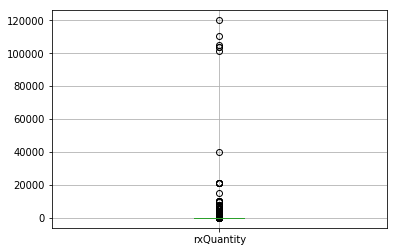

The boxplot shows significant outliers in the rxQuantity variable

Using simple z-score based methods to identify outliers as we are dealing with just one variable in the dataset with        potential outliers hence not going for multivariate outlier detection models


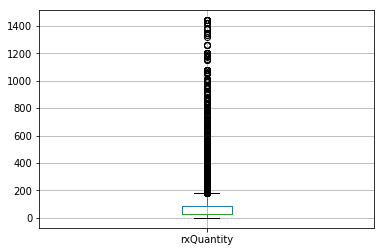

By setting z < 3 we have potentially removed most of the outliers as visible by the boxplot

Replacing the outliers with median values


In [5]:
# More data cleaning 
# Identifying outliers in the numerical fields in both the datasets
# Looking at rxQuantity in Meds data

import matplotlib.pyplot as plt
meds_ds_3.boxplot(column = 'rxQuantity')
plt.show()
print 'The boxplot shows significant outliers in the rxQuantity variable'
print ''
print 'Using simple z-score based methods to identify outliers as we are dealing with just one variable in the dataset with \
       potential outliers hence not going for multivariate outlier detection models'

a = meds_ds_3[['rxQuantity']]
meds_ds_3['rxQuantity_zsc'] = (a - a.mean())/a.std()
meds_ds_3.loc[meds_ds_3['rxQuantity_zsc'] <3,['rxQuantity']].boxplot(column = ['rxQuantity'])
plt.show()
print ('By setting z < 3 we have potentially removed most of the outliers as visible by the boxplot')
print ''
print ('Replacing the outliers with median values')
meds_ds_3.loc[meds_ds_3['rxQuantity_zsc'] >3,'rxQuantity'] = meds_ds_3['rxQuantity'].median()

For age all the data lies within the whiskers for the boxplot hence no potential outliers to remove


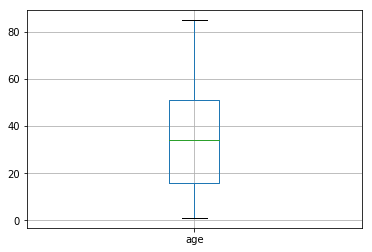

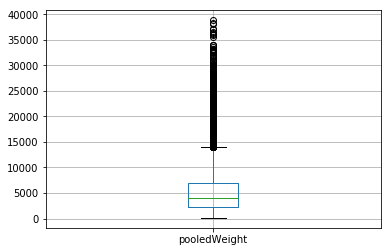

For pooled weight we can see potential outliers to remove as a lot of points tend to go beyond the whiskers
Again Using simple z-score based methods to identify outliers as we are dealing with just one variable in the dataset with        potential outliers hence not going for multivariate outlier detection models


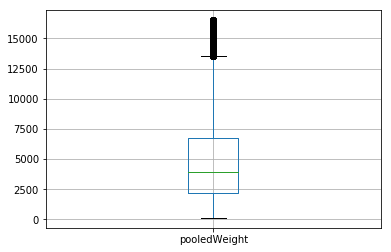

By setting z < 3 we have potentially removed most of the outliers as visible by the boxplot

Replacing the outliers with median values


In [6]:
# Looking at pooled weight in base data (As we can see that age and panel have no outliers from the min max values and boxplot)
#from sklearn.neighbors import LocalOutlierFactor


import matplotlib.pyplot as plt
base_ds_3.boxplot(column = ['age'])
print ('For age all the data lies within the whiskers for the boxplot hence no potential outliers to remove')
plt.show()
base_ds_3.boxplot(column = ['pooledWeight'])
plt.show()
print ('For pooled weight we can see potential outliers to remove as a lot of points tend to go beyond the whiskers')

print ('Again Using simple z-score based methods to identify outliers as we are dealing with just one variable in the dataset with \
       potential outliers hence not going for multivariate outlier detection models')


a = base_ds_3.iloc[:,2]
base_ds_3['poolw_zsc'] = (a - a.mean())/a.std()
base_ds_3.loc[base_ds_3['poolw_zsc'] <3,['pooledWeight']].boxplot(column = ['pooledWeight'])
plt.show()
print ('By setting z < 3 we have potentially removed most of the outliers as visible by the boxplot')
print ''
print ('Replacing the outliers with median values')
base_ds_3.loc[base_ds_3['poolw_zsc'] >3,'pooledWeight'] = base_ds_3['pooledWeight'].median()
base_ds_3.drop('poolw_zsc',axis = 1, inplace = True)

In [7]:
# # Getting the meds dataset ready for modelling
from sklearn import preprocessing
meds_ds_3 = meds_ds_3.drop(labels='rxQuantity_zsc', axis=1)

print'Assumptions :'
print 'If there are two entries with all the columns same they are assumed to be duplicate entries of the same instance hence all \
but one entry are removed'
print 'If there are two entries for the same id with different rxStartMonth and StartYear we can assume that they are two seperate \
instances of the individual taking the medicine and we can add the quantities to get the total of the medicine taken by the \
individual'
print 'If there are two entries for the same id with same rx name, start year and month but different rx Quantity or form or NDC \
they are assumed to be seperate instances and the qunaitites are got by adding such cases'
print ('')
print ('Considered as different unique events for the same individual in my approach')
print meds_ds_3[(meds_ds_3['id']==10012102) & (meds_ds_3['rxStartMonth']==5) & (meds_ds_3['rxName']=='SIMVASTATIN')]

# Grouping up the rxQuantity by the id and rxName 
meds_ds_4 = meds_ds_3.groupby(['id','rxName'],as_index= False)[['rxQuantity']].sum()

#Encoding the rxnames so numbers to make the analysis look simpler

le_rxname = preprocessing.LabelEncoder()
le_rxname.fit(meds_ds_4['rxName'])
meds_ds_4['rxName_tran'] = le_rxname.transform(meds_ds_4['rxName'])
meds_ds_4.drop(labels='rxName', axis=1,inplace = True)

# Trasnforming the rx names into columns and quanties into cell values (making id as unit of evaluation)
meds_ds_pvt = meds_ds_4.pivot(index='id', columns='rxName_tran', values='rxQuantity').reset_index()
meds_ds_pvt.fillna(0,inplace = True)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
print 'Transformed set'
meds_ds_pvt.head(10)

# Checking transformed set data
print 'rxQuantity same in both orignal and transformed' \
if round(meds_ds_pvt.iloc[:,1:].sum().sum()) == round(meds_ds_4['rxQuantity'].sum()) else 'rxQunatity not matching'

Assumptions :
If there are two entries with all the columns same they are assumed to be duplicate entries of the same instance hence all but one entry are removed
If there are two entries for the same id with different rxStartMonth and StartYear we can assume that they are two seperate instances of the individual taking the medicine and we can add the quantities to get the total of the medicine taken by the individual
If there are two entries for the same id with same rx name, start year and month but different rx Quantity or form or NDC they are assumed to be seperate instances and the qunaitites are got by adding such cases

Considered as different unique events for the same individual in my approach
             id  rxStartMonth  rxStartYear       rxName           rxNDC  \
24     10012102         5.000     2010.000  SIMVASTATIN 16714068201.000   
30     10012102         5.000     2010.000  SIMVASTATIN 16714068201.000   
31     10012102         5.000     2010.000  SIMVASTATIN 1671406

#  Question - 1

In [8]:
len(base_ds_3), len(base_ds_3['id'].unique()) # Checking if there are multiple rows for a single id or not
print ('There is one row per one id')

#Question - 1 (Top 3 common medication for each disease)

Q_1_res = {}                            # Empty dict to store disease top medicine pairs
for i in base_ds_3.columns[-10:]:
    base_ds_3_sub = base_ds_3.loc[base_ds_3[i] == 'Yes',['id',i]]  # Creating a subset of base df of all those who had the disease
    ds = meds_ds_pvt.merge(base_ds_3_sub,on= ['id'],how = 'right') # Merging to meds file
    out = ds[ds.columns[1:-1]].astype(bool).sum(axis=0).sort_values(ascending = False).head(3) # Selecting top 3 medicines taken
    
    Q_1_res[i] = zip(list(le_rxname.inverse_transform(list(out.index))),((out/len(ds))*100).round()) # Calculating % and adding to
    #le_rxname.inverse_transform(list(out.index))                                                    # dict along with medicine name

print 'Top 3 Medications for each disease along with the Percent of Population who took the medicine of those who had the disease :'
for i,j in Q_1_res.items():
    print i + ':     ' + str(j)

There is one row per one id
Top 3 Medications for each disease along with the Percent of Population who took the medicine of those who had the disease :
chdDiagnosed:     [('SIMVASTATIN', 29.0), ('LISINOPRIL', 29.0), ('FUROSEMIDE', 26.0)]
strokeDiagnosed:     [('SIMVASTATIN', 28.0), ('LISINOPRIL', 28.0), ('FUROSEMIDE', 23.0)]
diabetesDiagnosed:     [('METFORMIN', 38.0), ('LISINOPRIL', 31.0), ('SIMVASTATIN', 26.0)]
miDiagnosed:     [('LISINOPRIL', 32.0), ('SIMVASTATIN', 30.0), ('FUROSEMIDE', 27.0)]
highBPDiagnosed:     [('LISINOPRIL', 29.0), ('SIMVASTATIN', 23.0), ('HYDROCHLOROTHIAZIDE', 18.0)]
heartFailureDiagnosed:     [('FUROSEMIDE', 57.0), ('LISINOPRIL', 38.0), ('CARVEDILOL', 27.0)]
anginaDiagnosed:     [('LISINOPRIL', 27.0), ('SIMVASTATIN', 27.0), ('FUROSEMIDE', 25.0)]
otherHDDiagnosed:     [('LISINOPRIL', 25.0), ('SIMVASTATIN', 23.0), ('FUROSEMIDE', 22.0)]
asthmaDiagnosed:     [('ALBUTEROL', 34.0), ('AMOXICILLIN', 27.0), ('AZITHROMYCIN', 27.0)]
emphysemaDiagnosed:     [('LISINOPRI

# Question - 2

In [9]:
# Q - 2 Most indicative medicines for each disease

#Merging the whole base data with the transformed meds data
merg_set = meds_ds_pvt.merge(base_ds_3,on= ['id'],how = 'right') # Right join as we want everyone from the base data set

# Creating numeric variables out of Yes/No/Inapplicable/Refused ....

print 'Assuming that Inapplicable is No as well because if someone is Inapplicable he/she definitly does not have the condition\
       because they are inapplicable because of age etc or because probability for having the disease is almost 0 for them'

print 'Also all the other fields including refused and not sure have been taken as no as well - Their counts are pretry insignificant\
       as well'

for i in merg_set.columns[-10:]:
    merg_set[i] = merg_set[i].apply(lambda x: 1 if x == 'Yes' else 0 )

# Filling the na values (because of those individuals who didnt take any medication) with 0
merg_set.fillna(0,inplace = True)

Assuming that Inapplicable is No as well because if someone is Inapplicable he/she definitly does not have the condition       because they are inapplicable because of age etc or because probability for having the disease is almost 0 for them
Also all the other fields including refused and not sure have been taken as no as well - Their counts are pretry insignificant       as well


In [10]:
res = {}   # Dictionary with top 3 most indicative medicines for each disease
for j in merg_set.columns[-10:]:

    corr = {}
    a = merg_set[j]   
    for i in merg_set.columns[1:-16]:
        corr[i] = round(a.corr(merg_set[i]),4)   # Calc corr between one dependent variable and all IV's
    ls = []
    for i in corr.items():
        ls.append(i)
    srt = sorted(ls,key=operator.itemgetter((1)),reverse=True)  # Sorting the corr to get highest and lowest
    # Getting Top 3 positive corr variables 
    fnl = srt[0:3]
    
    i = -1
    # Getting all negetive corr variables where the corr is >0.2 in magnitude
    while srt[i][1] < - 0.2:
        fnl.append(srt[i])
        i = i - 1
    fnl_2 = []
    for i in fnl:
        fnl_2.append((le_rxname.inverse_transform(i[0]),i[1])) # Getting the medication names
    res[j] = fnl_2
for i,j in res.items():
    print i + ':     ' + str(j)

chdDiagnosed:     [('CARVEDILOL', 0.1816), ('DIGOXIN', 0.1647), ('METOPROLOL', 0.1565)]
strokeDiagnosed:     [('AGGRENOX', 0.1383), ('FUROSEMIDE', 0.1377), ('SIMVASTATIN', 0.1132)]
diabetesDiagnosed:     [('METFORMIN', 0.402), ('ACTOS', 0.2658), ('TRUETRACK SMART SYSTEM (MONITOR)', 0.22)]
miDiagnosed:     [('CARVEDILOL', 0.162), ('DIGOXIN', 0.1307), ('CARVEDILOL (FILM-COATED)', 0.1097)]
highBPDiagnosed:     [('SIMVASTATIN', 0.2094), ('DIOVAN', 0.144), ('CARVEDILOL', 0.1132)]
heartFailureDiagnosed:     [('FUROSEMIDE', 0.2791), ('CARVEDILOL', 0.1959), ('DIGOXIN', 0.1378)]
anginaDiagnosed:     [('FUROSEMIDE', 0.1421), ('ISOSORB MONO', 0.1391), ('ISOSORBIDE MONONITRATE', 0.1313)]
otherHDDiagnosed:     [('DIGOXIN', 0.1596), ('PLAVIX', 0.1549), ('CARVEDILOL', 0.1528)]
asthmaDiagnosed:     [('ADVAIR DISKUS', 0.1519), ('ALBUTEROL', 0.1516), ('ADVAIR DISKU', 0.145)]
emphysemaDiagnosed:     [('SPIRIVA', 0.2526), ('COMBIVENT', 0.1499), ('ALBUTEROL', 0.1448)]


# Question -3

In [11]:
# Q- 3 Build a model to predict any one of the diseases - predicting highBPDiagnosed (Cosndering the demographic variables also)

merg_set_mod = merg_set[merg_set.columns[:-9]]

# Encoding the sex,race and married variables :
from collections import defaultdict
enc = defaultdict(preprocessing.LabelEncoder)  # Creating a default dict of label encoders to remember each label for inverse later

for i in merg_set_mod.columns[-4:-1]:
    merg_set_mod[i] = enc[i].fit_transform(merg_set_mod[i])

merg_set_mod.to_csv('Clover_modelling_set.csv')  # Moving to a second notebook beacuse of memory issues

C:\Users\dhrugarg\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
